# CATBOOST VS CUSTOM MODEL
The idea of this Notebook is to compare the Results of our model with CatBoost and a linear regression (R*** tool).

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import xgboost
from xgboost import XGBRegressor
import catboost
from catboost import CatBoostRegressor

First we import the Hdataset.

In [89]:
data = pd.read_csv('../Data/TFM_Hdataset_Gtrends.csv', index_col=0)
data

,Description,Seasonality,Year,Week,Channel,WSSI Category,LIMITED EDITION STYLES,Originals,Source,sales,...,Price,Discount,Margin,RRP,Markdown,Cost,month,Channel2,CategoryCluster,ProductCluster
0,Astrid,OLD,2017,1,DE Direct,Womens Active Shoes,0.0,0.0,NONE,1.0,...,38.526679,0.000000,25.758448,50.378410,11.851731,12.768232,1,US,Cluster 6,Cluster 2
1,Charmaine,SS,2017,1,DE Direct,Womens Formal Shoes,0.0,0.0,NONE,1.0,...,58.225767,0.000000,44.100962,58.395499,0.169733,14.124805,1,US,Cluster 0,Cluster 2
2,Chile,SS,2017,1,DE Direct,Womens Casual Shoes,0.0,0.0,NONE,1.0,...,58.225767,0.000000,46.649675,58.395499,0.169733,11.576091,1,US,Cluster 3,Cluster 7
3,Devotion,AW,2017,1,DE Direct,Womens Slippers,0.0,0.0,NONE,2.0,...,26.457288,0.000000,17.882101,34.688819,8.231530,8.575187,1,US,Cluster 0,Cluster 2
4,Donna,CONT,2017,1,DE Direct,Womens Formal Shoes,0.0,0.0,NONE,1.0,...,69.982735,0.000000,54.114939,70.192570,0.209836,15.867796,1,US,Cluster 0,Cluster 7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324424,Waltham,AW,2021,50,Wholesale,Womens Casual Boots,0.0,0.0,MANUFACTURED,20.0,...,52.500000,0.000000,29.532000,87.500000,35.000000,22.968000,12,UK,Cluster 4,Cluster 6
324425,Whisper,AW,2021,50,Wholesale,Womens Casual Boots,0.0,0.0,MANUFACTURED,74.0,...,45.586351,0.000000,25.807703,70.833333,25.246982,19.778649,12,UK,Cluster 4,Cluster 4
324426,Whisper,CONT,2021,50,Wholesale,Womens Casual Boots,0.0,0.0,MANUFACTURED,83.0,...,54.996024,0.046867,35.907952,70.833333,15.790441,19.088072,12,UK,Cluster 4,Cluster 4
324427,Wrap,AW,2021,50,Wholesale,Womens Slippers,0.0,0.0,MANUFACTURED,28.0,...,29.170000,0.000000,14.480000,49.166666,19.996666,14.690000,12,UK,Cluster 0,Cluster 2


In [90]:
data['Date'] = pd.to_datetime(data['Date'])

conditions = [(data['Year']!= 2019) & (data['Year']!= 2021),
              (data['Year']== 2019),
              (data['Year']!= 2019)]

vals = [np.sin(2*np.pi*data['Week']/52),
        np.sin(2*np.pi*data['Week']/53),
        np.sin(2*np.pi*data['Week']/50)
       ]

vals2 = [np.cos(2*np.pi*data['Week']/52),
        np.cos(2*np.pi*data['Week']/53),
        np.cos(2*np.pi*data['Week']/50)
       ]
data['Week_sin'] = np.select(conditions,vals)
data['Week_cos'] = np.select(conditions,vals2)

In [75]:
import warnings
warnings.filterwarnings("ignore")

In [91]:
data = data[['Description', 'Seasonality', 'Year', 'Week_sin','Week_cos', 'Channel',
       'WSSI Category', 'Originals', 'Source',
       'gender', 'style', 'prev_sales2', 'prev_sales3',
       'prev_sales4', 'Price', 'Discount', 'prev_mean_price',
       'RRP', 'Markdown', 'Cost', 'CategoryCluster','Date',
       'ProductCluster','sales']]

In [125]:
def catb(data_s):
    
    categorical_features_indices = np.where(data_s.dtypes != np.float64)[0]
    
    X = data_s[(data_d['Date']<'01-01-2019')].values
    T = data_s[(data_d['Date']>='01-01-2019')&(data_d['Date']<'01-01-2020')].values 

    X_train,y_train = X[:,:-1], X[:,-1]
    X_test,y_test = T[:,:-1], T[:,-1] 

    mod_cb = CatBoostRegressor(iterations=60, depth=10, learning_rate=0.1, od_type= "Iter", loss_function='RMSE')
    mod_cb = mod_cb.fit(X_train,y_train,cat_features=categorical_features_indices,eval_set=(X_test, y_test),plot=True)
    y_hat = mod_cb.predict(X_test)
    y_hat_m = mod_cb.predict(X_train)
    
    score = r2_score(y_test,y_hat)
    score2 = mean_squared_error(y_test,y_hat)
    score3 = mean_absolute_error(y_test,y_hat)
    
    score_m = r2_score(y_train,y_hat_m)
    score2_m = mean_squared_error(y_train,y_hat_m)
    score3_m = mean_absolute_error(y_train,y_hat_m)

    return y_hat, score, score2, score3, y_hat_m, score_m, score2_m, score3_m



Cluster 6


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 94.1966408	test: 76.2486497	best: 76.2486497 (0)	total: 55ms	remaining: 3.25s
1:	learn: 90.2202796	test: 73.2523166	best: 73.2523166 (1)	total: 109ms	remaining: 3.16s
2:	learn: 86.5790290	test: 70.3035366	best: 70.3035366 (2)	total: 172ms	remaining: 3.26s
3:	learn: 83.5192341	test: 68.5507583	best: 68.5507583 (3)	total: 225ms	remaining: 3.15s
4:	learn: 80.8960303	test: 66.5051510	best: 66.5051510 (4)	total: 282ms	remaining: 3.1s
5:	learn: 78.4351885	test: 64.9602087	best: 64.9602087 (5)	total: 340ms	remaining: 3.06s
6:	learn: 75.9877431	test: 63.5640902	best: 63.5640902 (6)	total: 397ms	remaining: 3.01s
7:	learn: 74.0912055	test: 62.2190092	best: 62.2190092 (7)	total: 454ms	remaining: 2.95s
8:	learn: 72.3444737	test: 61.2584411	best: 61.2584411 (8)	total: 510ms	remaining: 2.89s
9:	learn: 70.6038923	test: 60.4044017	best: 60.4044017 (9)	total: 565ms	remaining: 2.83s
10:	learn: 69.0984136	test: 59.5744268	best: 59.5744268 (10)	total: 618ms	remaining: 2.75s
11:	learn: 67.3987315

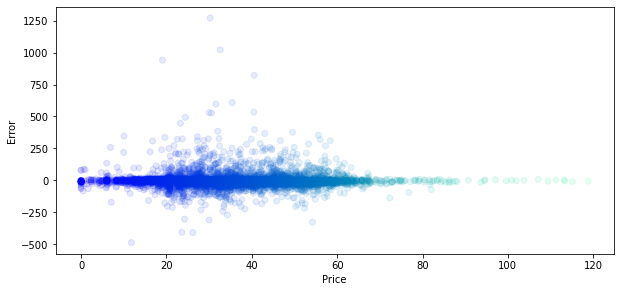

Sales vs error


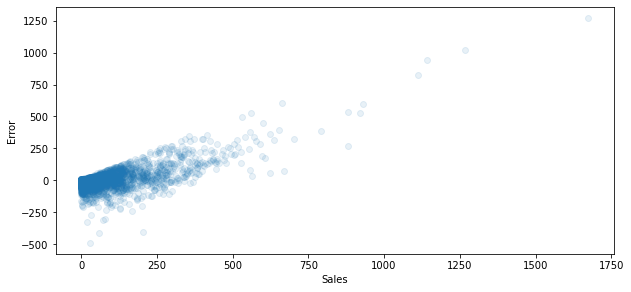

Cluster 0


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 74.6616435	test: 53.1004951	best: 53.1004951 (0)	total: 74.8ms	remaining: 4.41s
1:	learn: 71.6559304	test: 51.1608853	best: 51.1608853 (1)	total: 156ms	remaining: 4.53s
2:	learn: 68.8500201	test: 49.7670559	best: 49.7670559 (2)	total: 262ms	remaining: 4.97s
3:	learn: 66.2252448	test: 48.7626576	best: 48.7626576 (3)	total: 366ms	remaining: 5.13s
4:	learn: 64.1581216	test: 47.5925863	best: 47.5925863 (4)	total: 452ms	remaining: 4.97s
5:	learn: 62.0719769	test: 46.6846696	best: 46.6846696 (5)	total: 532ms	remaining: 4.79s
6:	learn: 60.3680090	test: 45.8939307	best: 45.8939307 (6)	total: 604ms	remaining: 4.57s
7:	learn: 58.5884451	test: 45.0691412	best: 45.0691412 (7)	total: 682ms	remaining: 4.43s
8:	learn: 57.1000198	test: 44.4793016	best: 44.4793016 (8)	total: 754ms	remaining: 4.27s
9:	learn: 55.8236070	test: 43.8947017	best: 43.8947017 (9)	total: 830ms	remaining: 4.15s
10:	learn: 54.6672710	test: 43.4365357	best: 43.4365357 (10)	total: 908ms	remaining: 4.04s
11:	learn: 53.7316

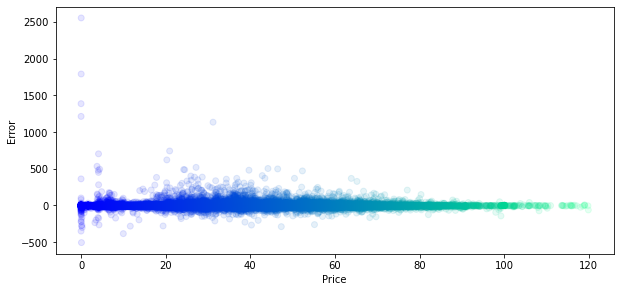

Sales vs error


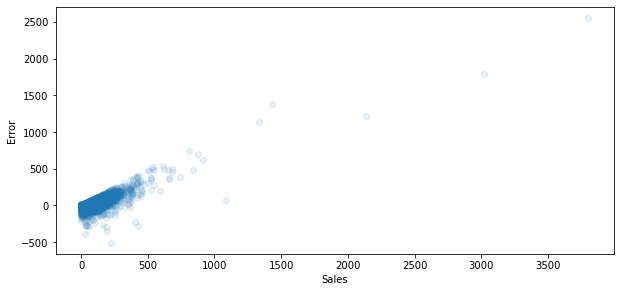

Cluster 3


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 114.2454685	test: 87.5342700	best: 87.5342700 (0)	total: 57.6ms	remaining: 3.4s
1:	learn: 108.8569059	test: 82.0917697	best: 82.0917697 (1)	total: 119ms	remaining: 3.46s
2:	learn: 104.1316421	test: 77.4341410	best: 77.4341410 (2)	total: 191ms	remaining: 3.63s
3:	learn: 99.7711980	test: 72.9430189	best: 72.9430189 (3)	total: 257ms	remaining: 3.59s
4:	learn: 96.1592539	test: 69.9908712	best: 69.9908712 (4)	total: 329ms	remaining: 3.62s
5:	learn: 92.5411329	test: 66.3585259	best: 66.3585259 (5)	total: 395ms	remaining: 3.55s
6:	learn: 89.2205740	test: 63.4757934	best: 63.4757934 (6)	total: 459ms	remaining: 3.47s
7:	learn: 86.3041678	test: 60.8546178	best: 60.8546178 (7)	total: 521ms	remaining: 3.39s
8:	learn: 83.7285121	test: 58.8369040	best: 58.8369040 (8)	total: 587ms	remaining: 3.32s
9:	learn: 81.4414289	test: 56.8717319	best: 56.8717319 (9)	total: 653ms	remaining: 3.26s
10:	learn: 79.1574798	test: 55.1454441	best: 55.1454441 (10)	total: 715ms	remaining: 3.19s
11:	learn: 77.38

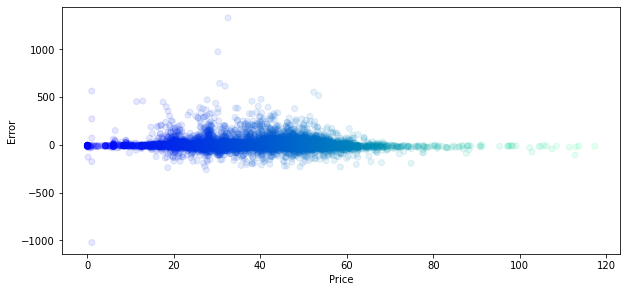

Sales vs error


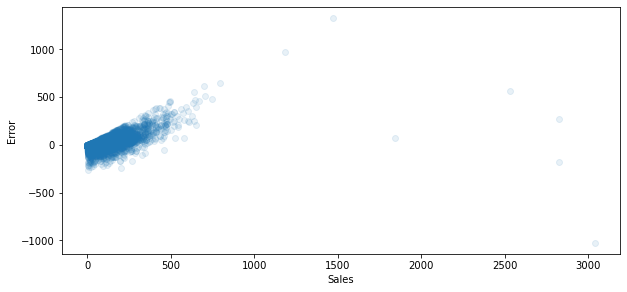

Cluster 2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 143.9253907	test: 146.7909588	best: 146.7909588 (0)	total: 46.1ms	remaining: 2.72s
1:	learn: 135.4598692	test: 138.9555620	best: 138.9555620 (1)	total: 89.7ms	remaining: 2.6s
2:	learn: 128.1003470	test: 133.4619342	best: 133.4619342 (2)	total: 139ms	remaining: 2.64s
3:	learn: 121.4652972	test: 130.0199498	best: 130.0199498 (3)	total: 196ms	remaining: 2.74s
4:	learn: 115.5323914	test: 124.9134777	best: 124.9134777 (4)	total: 250ms	remaining: 2.75s
5:	learn: 109.9816152	test: 120.4148340	best: 120.4148340 (5)	total: 305ms	remaining: 2.74s
6:	learn: 105.3757613	test: 117.0234350	best: 117.0234350 (6)	total: 351ms	remaining: 2.66s
7:	learn: 101.1609962	test: 113.2186711	best: 113.2186711 (7)	total: 377ms	remaining: 2.45s
8:	learn: 97.4053729	test: 111.2987654	best: 111.2987654 (8)	total: 424ms	remaining: 2.4s
9:	learn: 93.8385389	test: 108.0683616	best: 108.0683616 (9)	total: 469ms	remaining: 2.35s
10:	learn: 90.8219195	test: 106.1167525	best: 106.1167525 (10)	total: 521ms	remain

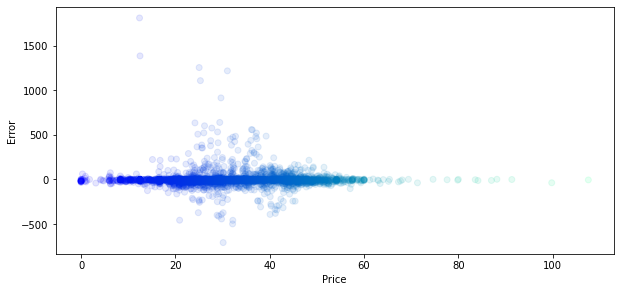

Sales vs error


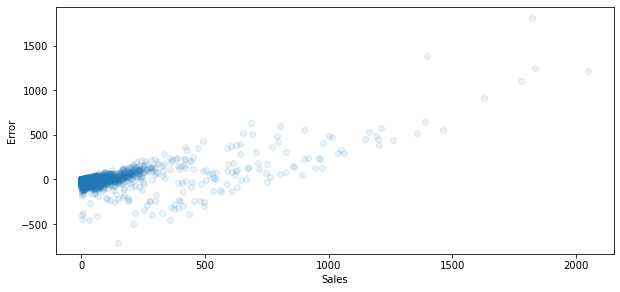

Cluster 5


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 127.5735662	test: 142.5492298	best: 142.5492298 (0)	total: 53.7ms	remaining: 3.17s
1:	learn: 121.2159923	test: 141.1385745	best: 141.1385745 (1)	total: 102ms	remaining: 2.96s
2:	learn: 114.8836132	test: 135.8496767	best: 135.8496767 (2)	total: 161ms	remaining: 3.06s
3:	learn: 109.1565763	test: 130.8521791	best: 130.8521791 (3)	total: 209ms	remaining: 2.92s
4:	learn: 104.1117695	test: 126.1028883	best: 126.1028883 (4)	total: 256ms	remaining: 2.82s
5:	learn: 99.6122299	test: 125.1525735	best: 125.1525735 (5)	total: 318ms	remaining: 2.86s
6:	learn: 95.8155178	test: 121.7800148	best: 121.7800148 (6)	total: 365ms	remaining: 2.76s
7:	learn: 92.4951799	test: 119.4652730	best: 119.4652730 (7)	total: 420ms	remaining: 2.73s
8:	learn: 89.4131272	test: 117.2587494	best: 117.2587494 (8)	total: 465ms	remaining: 2.64s
9:	learn: 86.6629668	test: 114.2540555	best: 114.2540555 (9)	total: 520ms	remaining: 2.6s
10:	learn: 84.3309264	test: 112.2515758	best: 112.2515758 (10)	total: 565ms	remaining

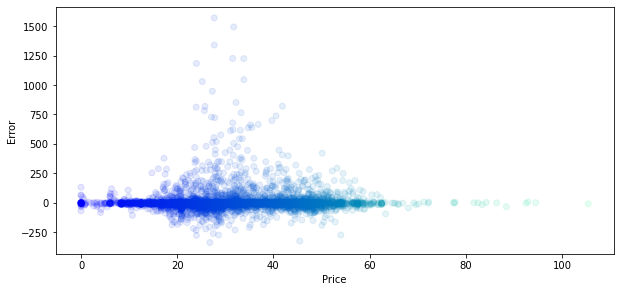

Sales vs error


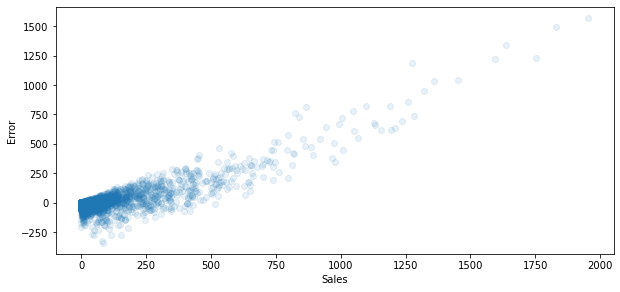

Cluster 4


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 178.1997413	test: 133.1978607	best: 133.1978607 (0)	total: 52.6ms	remaining: 3.1s
1:	learn: 168.1205304	test: 125.6963320	best: 125.6963320 (1)	total: 103ms	remaining: 2.98s
2:	learn: 157.9216009	test: 117.8712582	best: 117.8712582 (2)	total: 165ms	remaining: 3.14s
3:	learn: 149.3735145	test: 111.8927503	best: 111.8927503 (3)	total: 209ms	remaining: 2.93s
4:	learn: 141.0557146	test: 106.5309360	best: 106.5309360 (4)	total: 256ms	remaining: 2.82s
5:	learn: 133.6414179	test: 101.6827328	best: 101.6827328 (5)	total: 308ms	remaining: 2.77s
6:	learn: 127.5571593	test: 98.0118109	best: 98.0118109 (6)	total: 354ms	remaining: 2.68s
7:	learn: 121.9373493	test: 94.6150819	best: 94.6150819 (7)	total: 416ms	remaining: 2.7s
8:	learn: 116.5796041	test: 90.7984320	best: 90.7984320 (8)	total: 472ms	remaining: 2.68s
9:	learn: 111.8814272	test: 88.4507157	best: 88.4507157 (9)	total: 532ms	remaining: 2.66s
10:	learn: 107.7573084	test: 86.1912905	best: 86.1912905 (10)	total: 567ms	remaining: 2.5

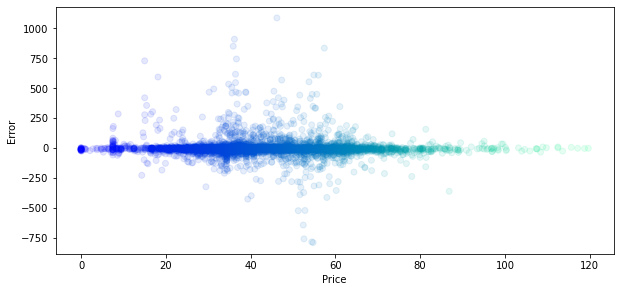

Sales vs error


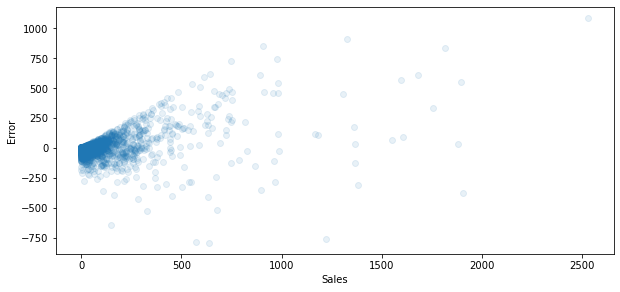

Cluster 1


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 218.4967398	test: 217.7887779	best: 217.7887779 (0)	total: 49ms	remaining: 2.89s
1:	learn: 201.9646958	test: 200.9828838	best: 200.9828838 (1)	total: 102ms	remaining: 2.95s
2:	learn: 186.1551197	test: 185.0864378	best: 185.0864378 (2)	total: 167ms	remaining: 3.17s
3:	learn: 172.2210676	test: 170.1707233	best: 170.1707233 (3)	total: 219ms	remaining: 3.06s
4:	learn: 159.9225454	test: 157.4176661	best: 157.4176661 (4)	total: 266ms	remaining: 2.92s
5:	learn: 149.4165222	test: 149.6595582	best: 149.6595582 (5)	total: 319ms	remaining: 2.87s
6:	learn: 140.3436534	test: 140.9244447	best: 140.9244447 (6)	total: 367ms	remaining: 2.78s
7:	learn: 131.0498755	test: 130.2213304	best: 130.2213304 (7)	total: 421ms	remaining: 2.73s
8:	learn: 122.8429922	test: 121.8345577	best: 121.8345577 (8)	total: 467ms	remaining: 2.65s
9:	learn: 115.9287767	test: 113.8318930	best: 113.8318930 (9)	total: 519ms	remaining: 2.6s
10:	learn: 109.7500321	test: 108.2922679	best: 108.2922679 (10)	total: 567ms	remai

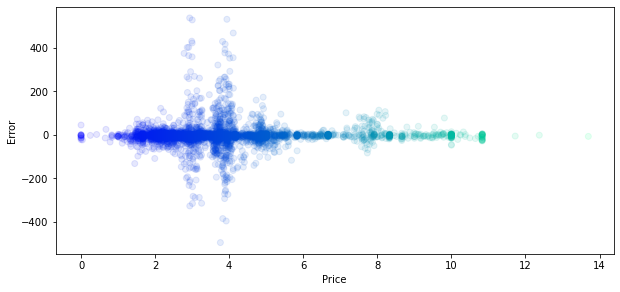

Sales vs error


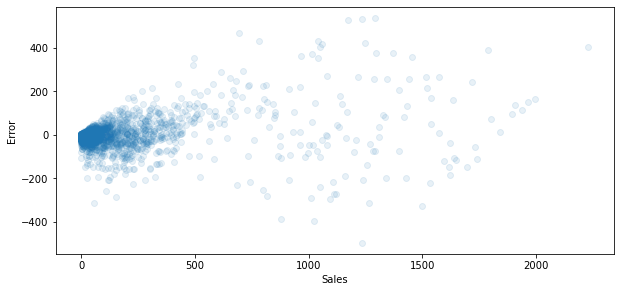

[0.58281362 0.54124184 0.71845175 0.66439607 0.60841071 0.73658403
 0.9462619 ]


In [126]:
scores = np.zeros((7))
scores2 = np.zeros((7))
scores3 = np.zeros((7))
scores_m = np.zeros((7))
scores2_m = np.zeros((7))
scores3_m = np.zeros((7))
errors = 0
j = 0

for category in data['CategoryCluster'].unique():
    data_d = data.loc[data['CategoryCluster']==category]    
    data_c = data_d.drop(['CategoryCluster','Date','prev_mean_price'], axis=1)
    
    print(category)
    y_hat, score, score2, score3, y_hat_m, score_m, score2_m, score3_m = catb(data_c)
    
    scores[j] = np.mean(score)
    scores2[j] = np.mean(score2)
    scores3[j] = np.mean(score3)
    scores_m[j] = np.mean(score_m)
    scores2_m[j] = np.mean(score2_m)
    scores3_m[j] = np.mean(score3_m)
    
    data_validation = data_d[(data_d['Date']>='01-01-2019')&(data_d['Date']<'01-01-2020')]
    data_validation['y_hat'] = y_hat
    data_validation['error'] = data_validation['sales'] - data_validation['y_hat']   
    
    data_validation_m = data_d[(data_d['Date']<'01-01-2019')]
    data_validation_m['y_hat_m'] = y_hat_m
    data_validation_m['error_m'] = data_validation_m['sales'] - data_validation_m['y_hat_m']
    
    if j==0:
        df = data_validation
        df['CategoryCluster'] = category
        df_m = data_validation_m
        df_m['CategoryCluster'] = category
    else:
        data_validation['CategoryCluster']=category
        data_validation_m['CategoryCluster']=category
        df = pd.concat([df,data_validation])
        df_m = pd.concat([df_m,data_validation_m])
    
    
    x = data_validation['Price']
    x2 = data_validation['sales']
    y = data_validation['error']
    
    print('Error Plots')
    plt.figure(figsize=(10,10))
    print('Price vs error')
    plt.subplot(211)
    plt.scatter(x,y, c=x, cmap='winter', alpha=0.1)
    plt.xlabel('Price')
    plt.ylabel('Error')
    plt.show()
    plt.figure(figsize=(10,10))
    print('Sales vs error')
    plt.subplot(212)
    plt.scatter(x2,y,  cmap='winter', alpha=0.1)
    plt.xlabel('Sales')
    plt.ylabel('Error')
    plt.show()
    
    j += 1
print(scores) 

## Results

Let's evaluate for the shoe care category products to be able to compare with our custom model

In [127]:
score_f = r2_score(df['sales'],df['y_hat'])
score2_f = mean_squared_error(df['sales'],df['y_hat'])
score3_f = mean_absolute_error(df['sales'],df['y_hat'])
score4_f = mean_absolute_percentage_error(df['sales'],df['y_hat'])
print(score_f,score2_f,score3_f,score4_f)

score_f = r2_score(df_m['sales'],df_m['y_hat_m'])
score2_f = mean_squared_error(df_m['sales'],df_m['y_hat_m'])
score3_f = mean_absolute_error(df_m['sales'],df_m['y_hat_m'])
score4_f = mean_absolute_percentage_error(df_m['sales'],df_m['y_hat_m'])
print(score_f,score2_f,score3_f,score4_f)

0.7421879413175426 2939.091886315814 20.13302804838379 297566340688386.8
0.8396581247615933 2318.0398874282496 17.926361236729324 287052176522641.56


0.8389314216186549 3142.670609959261 43.47203910938255 0.11886618846121874


<AxesSubplot:xlabel='Date'>

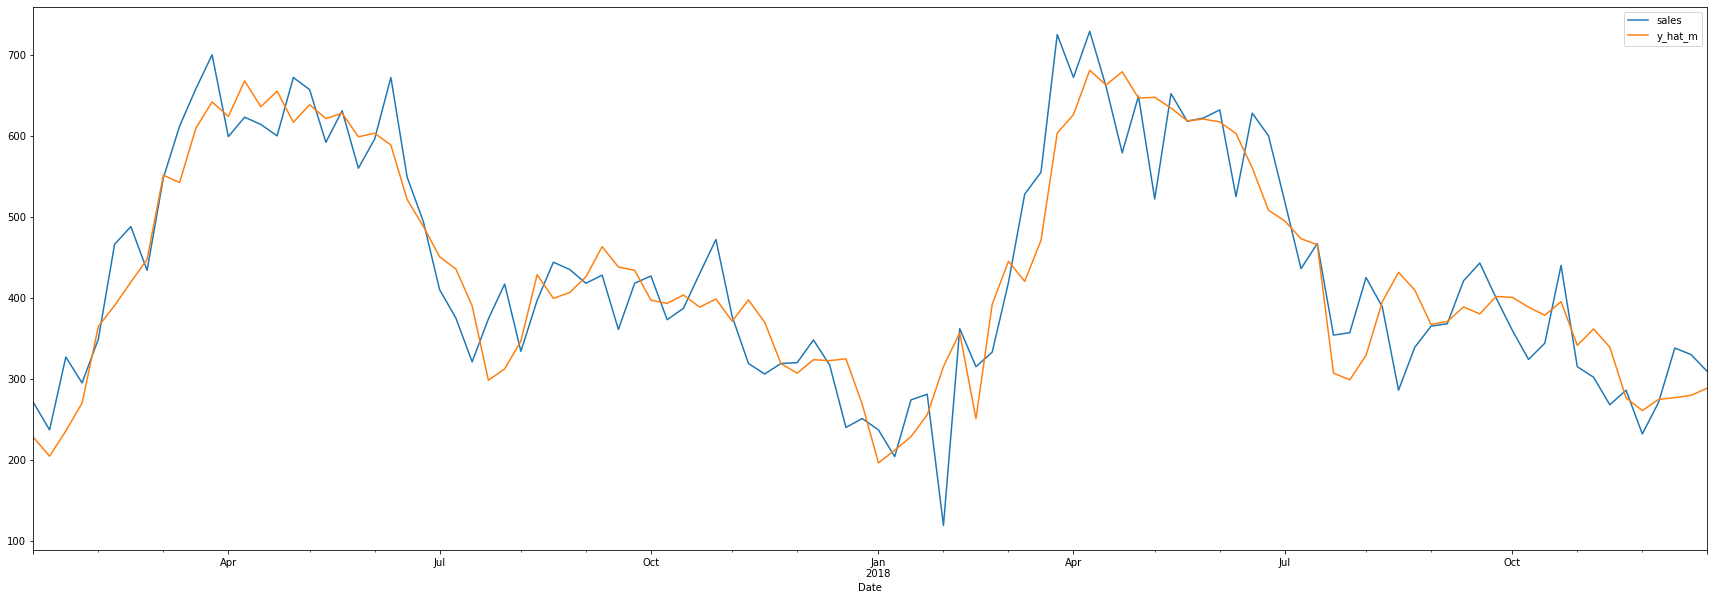

In [128]:
y_test_m=df_m[(df_m['Description']=='Footwear Cleaner')&(df_m['Channel']=='Retail - Full Price')]['sales']
y_hat_m=df_m[(df_m['Description']=='Footwear Cleaner')&(df_m['Channel']=='Retail - Full Price')]['y_hat_m']
score_fm = r2_score(y_test_m,y_hat_m)
score2_fm = mean_squared_error(y_test_m,y_hat_m)
score3_fm = mean_absolute_error(y_test_m,y_hat_m)
score4_fm = mean_absolute_percentage_error(y_test_m,y_hat_m)
print(score_fm,score2_fm,score3_fm,score4_fm)

df_m[(df_m['Description']=='Footwear Cleaner')&(df_m['Channel']=='Retail - Full Price')].sort_values('Date').plot(x='Date', y=['sales','y_hat_m'], figsize=(30,10))

0.3317249995553998 9077.831162517716 74.451398603996 0.1639194038650792


<AxesSubplot:xlabel='Date'>

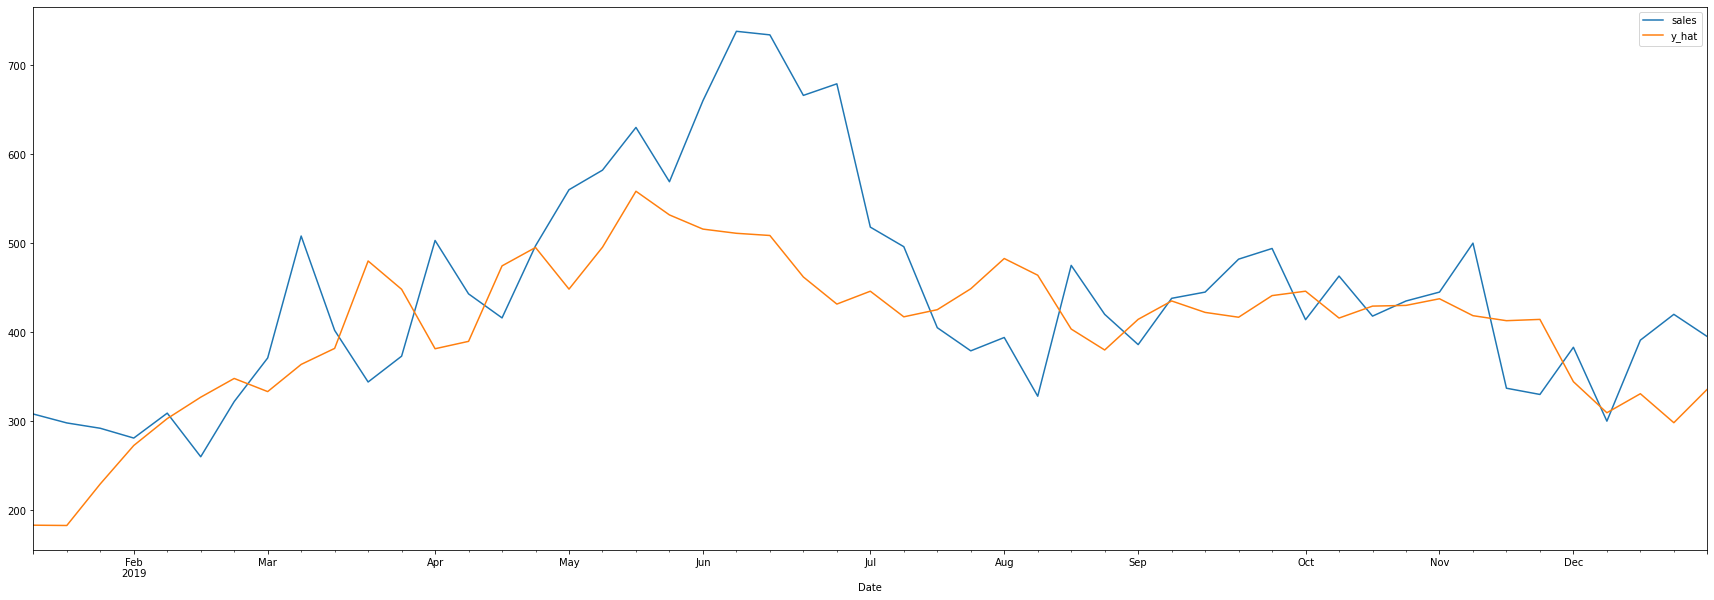

In [129]:
y_test=df[(df['Description']=='Footwear Cleaner')&(df['Channel']=='Retail - Full Price')]['sales']
y_hat=df[(df['Description']=='Footwear Cleaner')&(df['Channel']=='Retail - Full Price')]['y_hat']

score_f = r2_score(y_test,y_hat)
score2_f = mean_squared_error(y_test,y_hat)
score3_f = mean_absolute_error(y_test,y_hat)
score4_f = mean_absolute_percentage_error(y_test,y_hat)
print(score_f,score2_f,score3_f,score4_f)

df[(df['Description']=='Footwear Cleaner')&(df['Channel']=='Retail - Full Price')].plot(x='Date', y=['sales','y_hat'], figsize=(30,10))

We get worse results for prediction. We now compare the enhanced model and the catboost

In [108]:
def model6b(X,w):
    p_new = pnew2(X,w)
    beta = w[1]*X[:,1] + w[2]*X[:,2] + w[5]*X[:,3]
    y = np.exp(w[0] - beta*(np.log(p_new)))
    return y

def pnew2(X,w):
    p = w[3]*X[:,3] + w[4]*X[:,4] + w[6]*X[:,0]
    return p

data_m = df_m[(df_m['Description']=="Footwear Cleaner")&(df_m['Channel']=='Retail - Full Price')].sort_values('Date')
data_hm = data_m[['Price','Week_sin','Week_cos','Discount','prev_mean_price','sales']].values

data_p = df[(df['Description']=="Footwear Cleaner")&(df['Channel']=='Retail - Full Price')].sort_values('Date')
data_hp = data_p[['Price','Week_sin','Week_cos','Discount','prev_mean_price','sales']].values

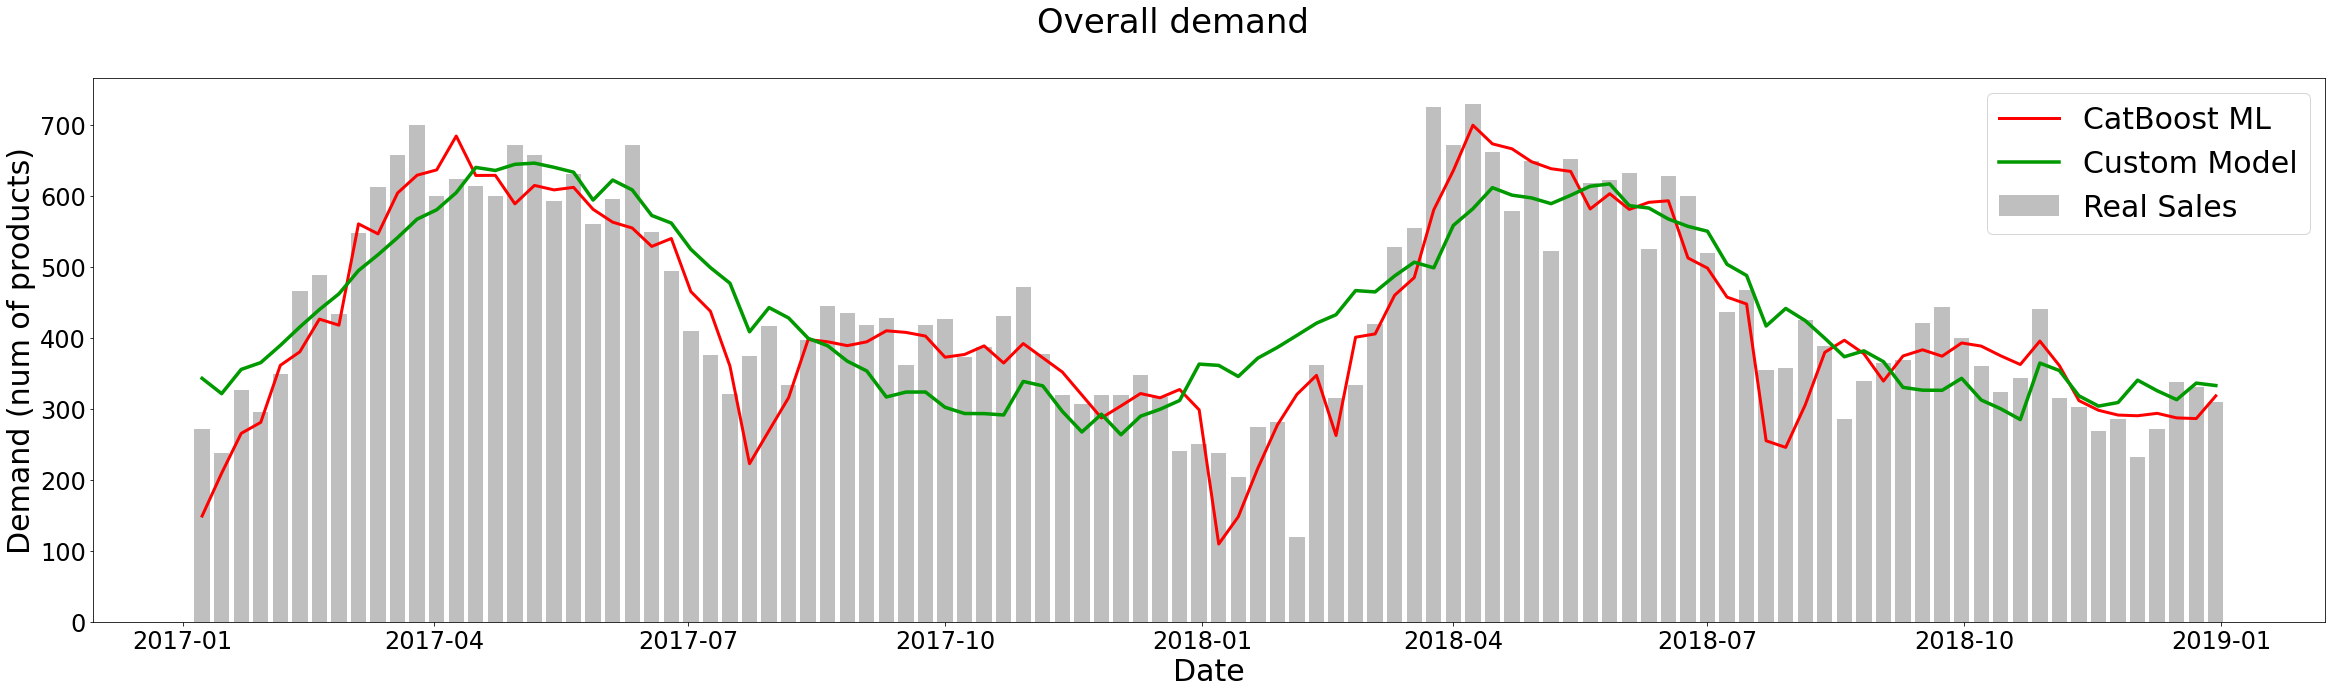

In [109]:
fig = plt.figure(figsize=(40,10))
fig.suptitle('Overall demand', fontsize=34)
plt.plot(data_m['Date'],data_m['y_hat_m'],c='red',linewidth=3, label='CatBoost ML')
plt.bar(data_m['Date'],data_m['sales'], color ='#bfbfbf', width = 5.5, label='Real Sales')
plt.plot(data_m['Date'],model6b(data_hm,[ 5.91370823, -1.7049693,   1.35986708, -0.25820421,  0.02712276, -3.30790766, 0.29491122]),c='#009900',linewidth=3.5, label='Custom Model')
plt.ylabel('Demand (num of products)', fontsize=30)
plt.xlabel('Date', fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=30)
plt.savefig('../Images/Demandmodelcatb.png')

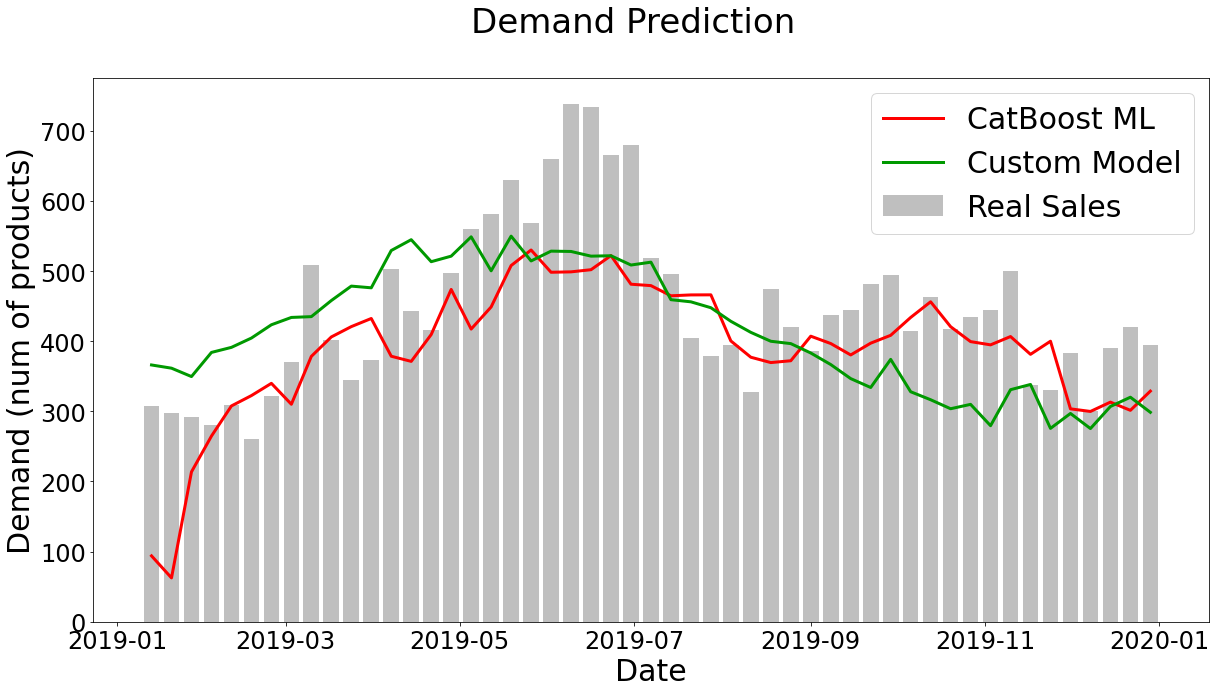

In [110]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Demand Prediction', fontsize=34)
plt.plot(data_p['Date'],data_p['y_hat'],c='red',linewidth=3, label='CatBoost ML')
plt.bar(data_p['Date'],data_p['sales'], color ='#bfbfbf', width = 5.5, label='Real Sales')
plt.plot(data_p['Date'],model6b(data_hp,[ 5.91370823, -1.7049693,   1.35986708, -0.25820421,  0.02712276, -3.30790766, 0.29491122]),c='#009900',linewidth=3, label='Custom Model')
plt.ylabel('Demand (num of products)', fontsize=30)
plt.xlabel('Date', fontsize=30)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=30)
plt.savefig('../Images/Demandmodelcatb_pred.png')

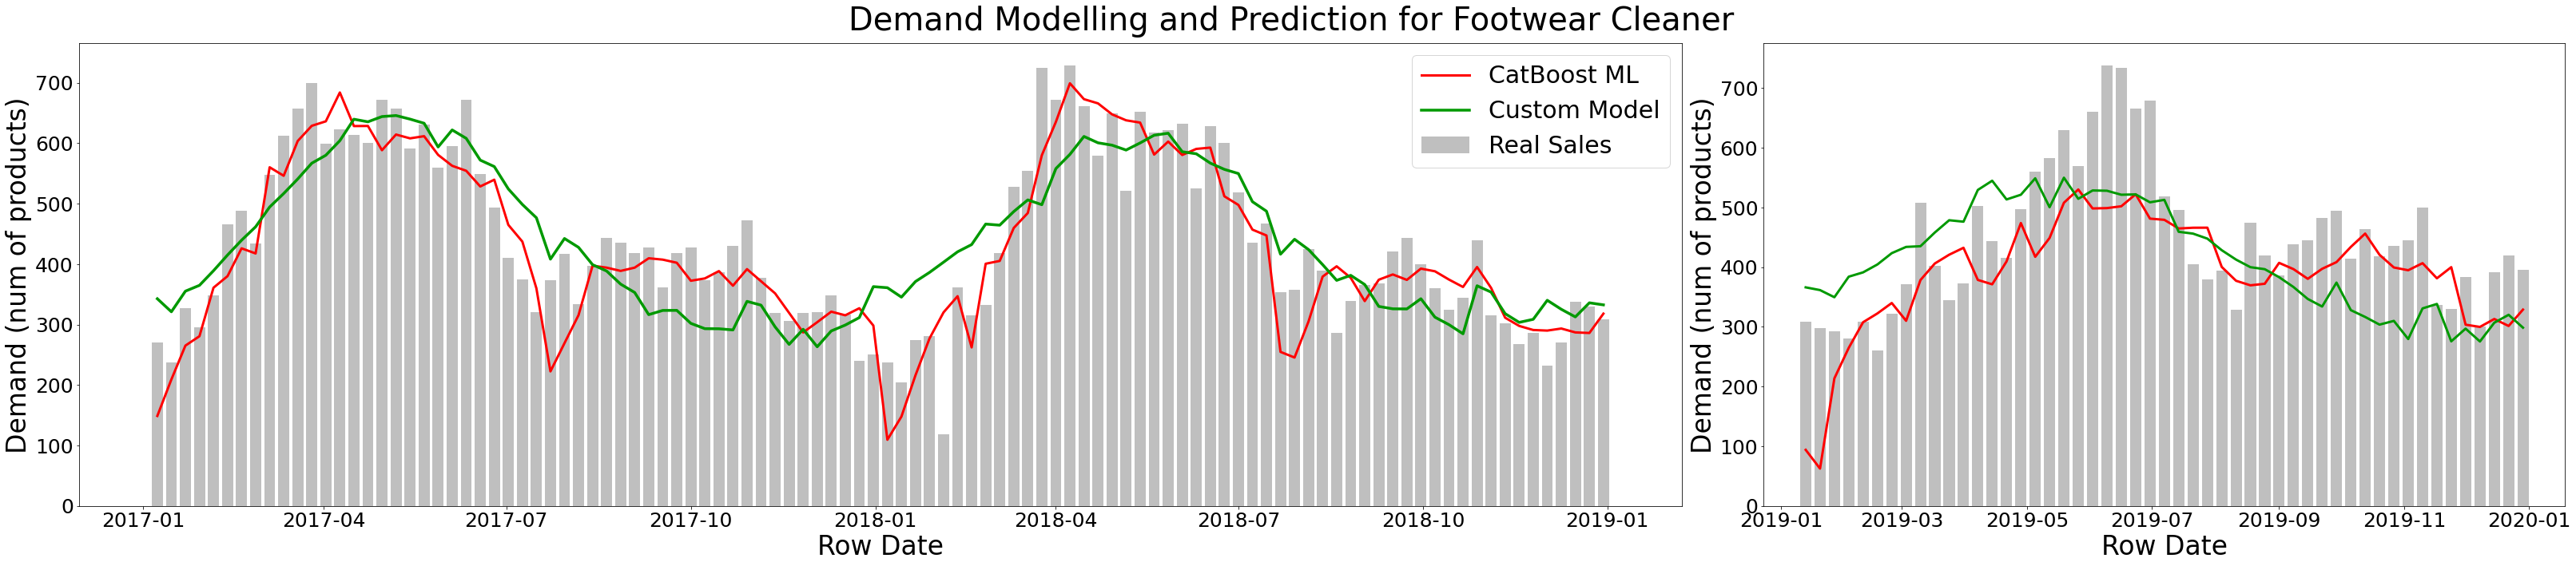

In [132]:
fig, ax = plt.subplots(1, 2,figsize=(45,10),gridspec_kw={'width_ratios': [6, 3]})

#ax[0].suptitle('Overall demand', fontsize=34)
ax[0].plot(data_m['Date'],data_m['y_hat_m'],c='red',linewidth=3, label='CatBoost ML')
ax[0].bar(data_m['Date'],data_m['sales'], color ='#bfbfbf', width = 5.5, label='Real Sales')
ax[0].plot(data_m['Date'],model6b(data_hm,[ 5.91370823, -1.7049693,   1.35986708, -0.25820421,  0.02712276, -3.30790766, 0.29491122]),c='#009900',linewidth=3.5, label='Custom Model')
ax[0].set_ylabel('Demand (num of products)', fontsize=33)
ax[0].set_xlabel('Row Date', fontsize=33)
ax[0].tick_params(axis='both', labelsize=25)
ax[0].legend(fontsize=30)

fig.suptitle('Demand Modelling and Prediction for Footwear Cleaner', fontsize=40)
ax[1].plot(data_p['Date'],data_p['y_hat'],c='red',linewidth=3, label='CatBoost ML')
ax[1].bar(data_p['Date'],data_p['sales'], color ='#bfbfbf', width = 5.5, label='Real Sales')
ax[1].plot(data_p['Date'],model6b(data_hp,[ 5.91370823, -1.7049693,   1.35986708, -0.25820421,  0.02712276, -3.30790766, 0.29491122]),c='#009900',linewidth=3, label='Custom Model')
ax[1].set_ylabel('Demand (num of products)', fontsize=33)
ax[1].set_xlabel('Row Date', fontsize=33)
ax[1].tick_params(axis='both', labelsize=25)
#ax[1].set_yticks(fontsize=24)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.7)
plt.tight_layout()
plt.savefig('../Images/Demandmodelcatb_pred.png')

Other product Hotter Women's Insoles

0.48371003122974887 3662.101265436635 44.51917180585353 0.14788120363759902


<AxesSubplot:xlabel='Date'>

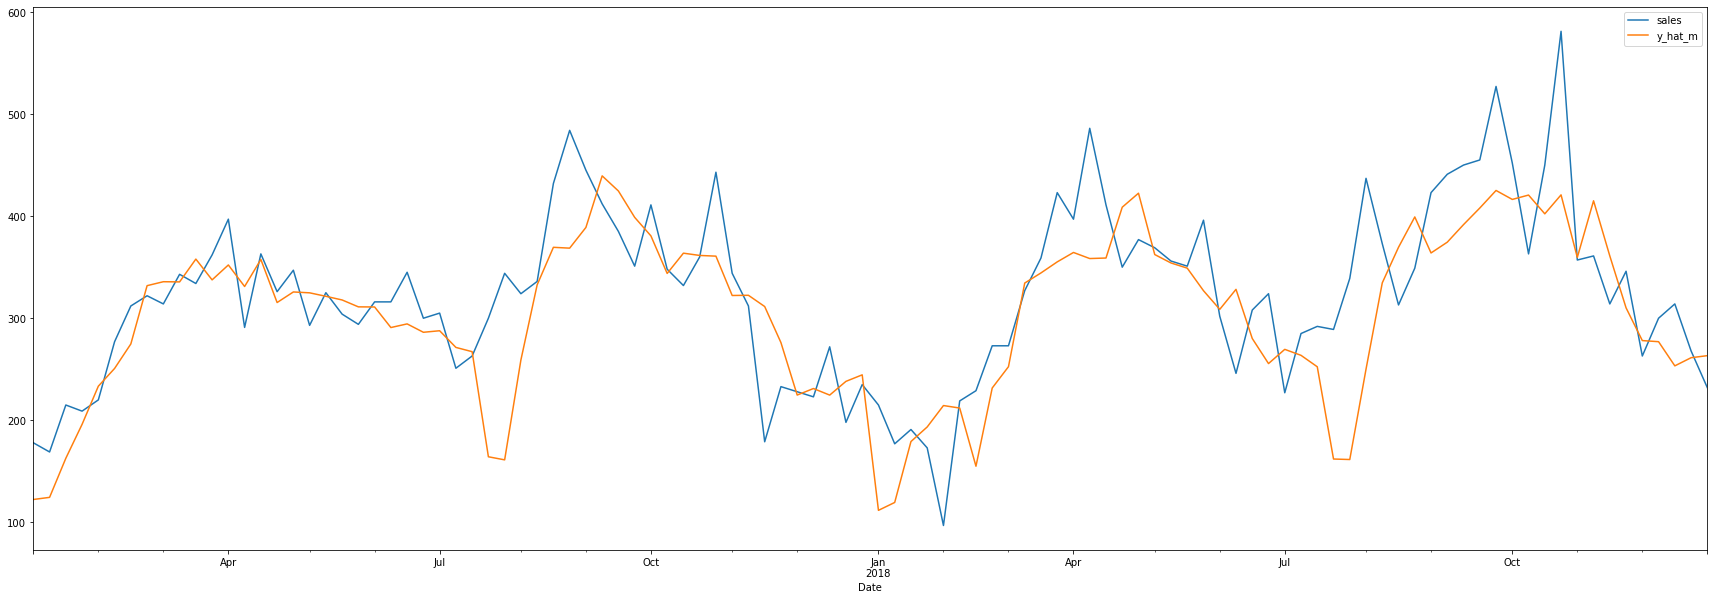

In [79]:
y_test_m=df_m[(df_m['Description']=="Hotter Women's Insoles")&(df_m['Channel']=='Retail - Full Price')]['sales']
y_hat_m=df_m[(df_m['Description']=="Hotter Women's Insoles")&(df_m['Channel']=='Retail - Full Price')]['y_hat_m']
score_fm = r2_score(y_test_m,y_hat_m)
score2_fm = mean_squared_error(y_test_m,y_hat_m)
score3_fm = mean_absolute_error(y_test_m,y_hat_m)
score4_fm = mean_absolute_percentage_error(y_test_m,y_hat_m)
print(score_fm,score2_fm,score3_fm,score4_fm)

df_m[(df_m['Description']=="Hotter Women's Insoles")&(df_m['Channel']=='Retail - Full Price')].sort_values('Date').plot(x='Date', y=['sales','y_hat_m'], figsize=(30,10))

0.06415093148426554 4058.0711157577016 48.34389826817187 0.149102073847597


<AxesSubplot:xlabel='Date'>

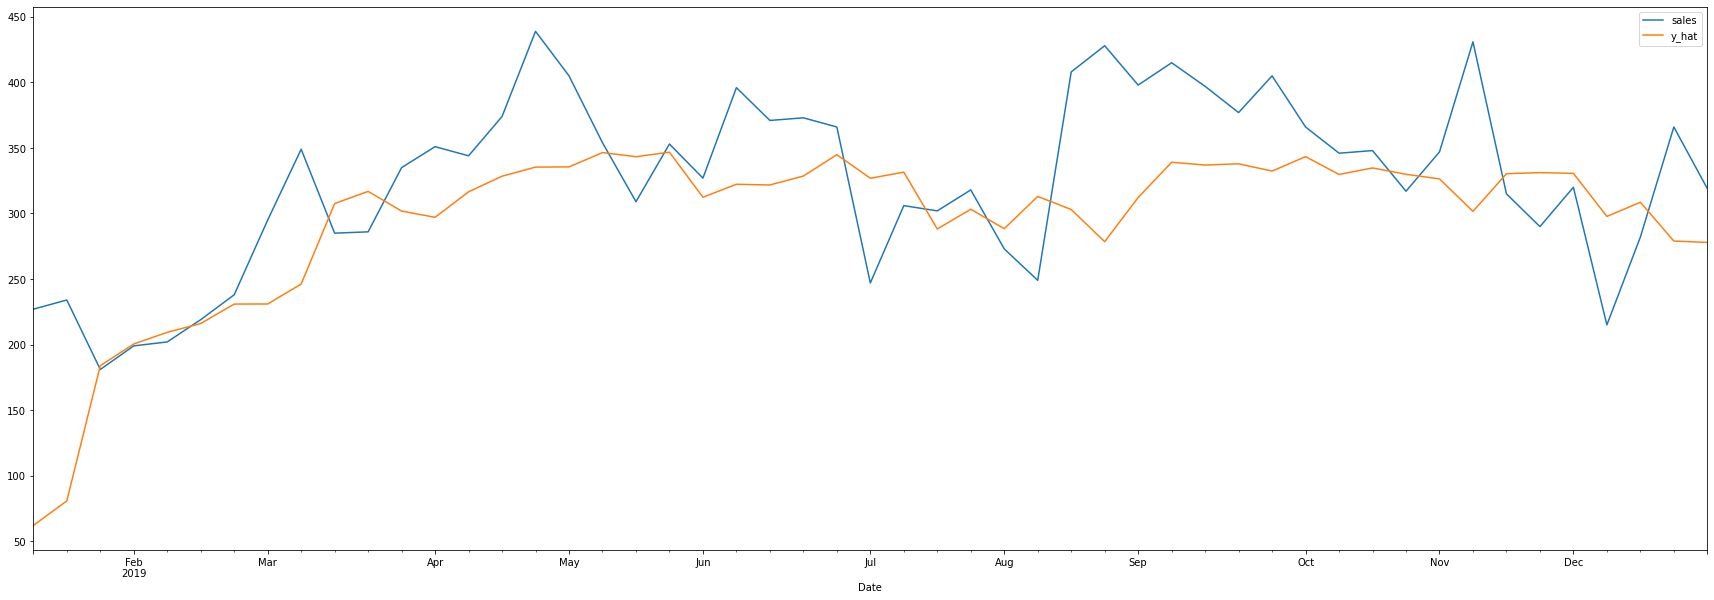

In [82]:
y_test=df[(df['Description']=="Hotter Women's Insoles")&(df['Channel']=='Retail - Full Price')]['sales']
y_hat=df[(df['Description']=="Hotter Women's Insoles")&(df['Channel']=='Retail - Full Price')]['y_hat']

score_f = r2_score(y_test,y_hat)
score2_f = mean_squared_error(y_test,y_hat)
score3_f = mean_absolute_error(y_test,y_hat)
score4_f = mean_absolute_percentage_error(y_test,y_hat)
print(score_f,score2_f,score3_f,score4_f)

df[(df['Description']=="Hotter Women's Insoles")&(df['Channel']=='Retail - Full Price')].plot(x='Date', y=['sales','y_hat'], figsize=(30,10))

In [85]:
data_m = df_m[(df_m['Description']=="Hotter Women's Insoles")&(df_m['Channel']=='Retail - Full Price')].sort_values('Date')
data_hm = data_m[['Price','Week_sin','Week_cos','Discount','prev_mean_price','sales']].values

data_p = df[(df['Description']=="Hotter Women's Insoles")&(df['Channel']=='Retail - Full Price')].sort_values('Date')
data_hp = data_p[['Price','Week_sin','Week_cos','Discount','prev_mean_price','sales']].values

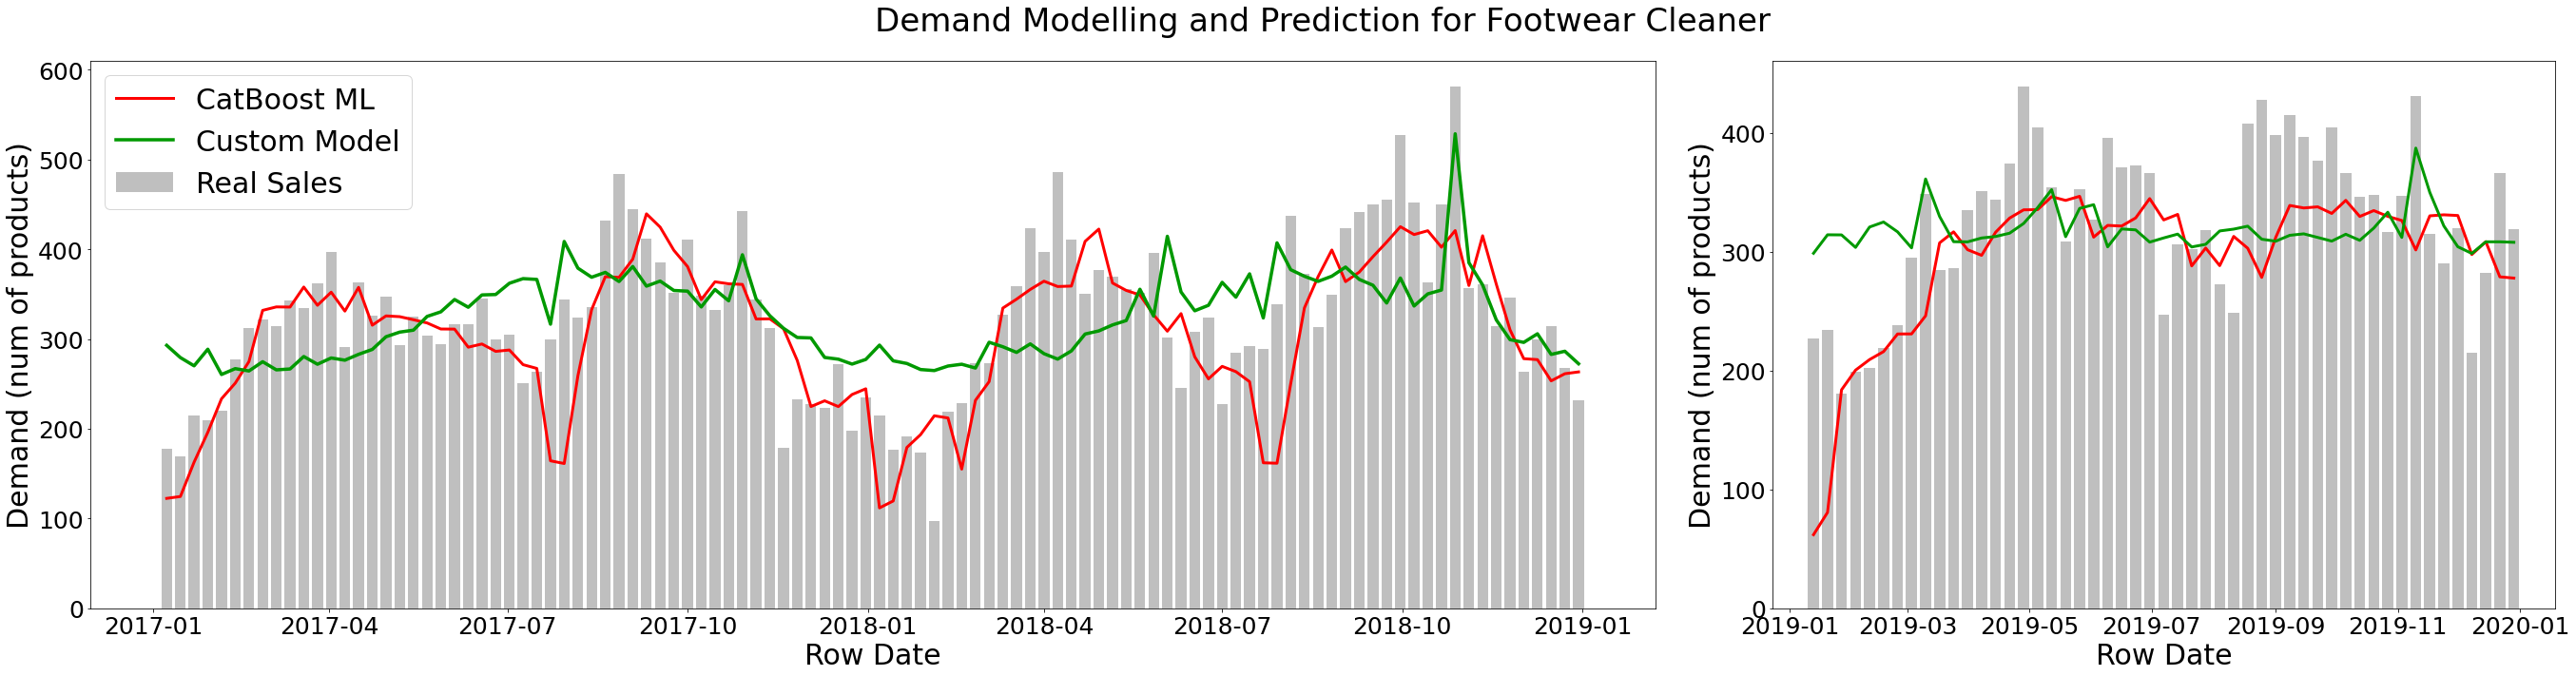

In [88]:
fig, ax = plt.subplots(1, 2,figsize=(45,10),gridspec_kw={'width_ratios': [6, 3]})

#ax[0].suptitle('Overall demand', fontsize=34)
ax[0].plot(data_m['Date'],data_m['y_hat_m'],c='red',linewidth=3, label='CatBoost ML')
ax[0].bar(data_m['Date'],data_m['sales'], color ='#bfbfbf', width = 5.5, label='Real Sales')
ax[0].plot(data_m['Date'],model6b(data_hm,[ 5.69809885,  0.07168655,  0.07552127,  4.08196248,  0.77508131, -0.34857881,0.21543885]),c='#009900',linewidth=3.5, label='Custom Model')
ax[0].set_ylabel('Demand (num of products)', fontsize=30)
ax[0].set_xlabel('Row Date', fontsize=30)
ax[0].tick_params(axis='both', labelsize=25)
ax[0].legend(fontsize=30)

fig.suptitle('Demand Modelling and Prediction for Footwear Cleaner', fontsize=34)
ax[1].plot(data_p['Date'],data_p['y_hat'],c='red',linewidth=3, label='CatBoost ML')
ax[1].bar(data_p['Date'],data_p['sales'], color ='#bfbfbf', width = 5.5, label='Real Sales')
ax[1].plot(data_p['Date'],model6b(data_hp,[ 5.69809885,  0.07168655,  0.07552127,  4.08196248,  0.77508131, -0.34857881,0.21543885]),c='#009900',linewidth=3, label='Custom Model')
ax[1].set_ylabel('Demand (num of products)', fontsize=30)
ax[1].set_xlabel('Row Date', fontsize=30)
ax[1].tick_params(axis='both', labelsize=25)
#ax[1].set_yticks(fontsize=24)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.7)

plt.savefig('../Images/Demandmodelcatb_pred.png')

In [ ]:
df_2 = data_validation_2
df_m_2 = data_validation_m_2
y_test_m_2=df_m_2[(df_m['Description']=='Footwear Cleaner')&(df_m_2['Channel']=='Retail - Full Price')]['sales']
y_hat_m_2=df_m_2[(df_m['Description']=='Footwear Cleaner')&(df_m_2['Channel']=='Retail - Full Price')]['y_hat_m']
score_fm = r2_score(y_test_m_2,y_hat_m_2)
score2_fm = mean_squared_error(y_test_m_2,y_hat_m_2)
score3_fm = mean_absolute_error(y_test_m_2,y_hat_m_2)
score4_fm = mean_absolute_percentage_error(y_test_m_2,y_hat_m_2)
print(score_fm,score2_fm,score3_fm,score4_fm)

We can see CatBoost performs better than the Custom Model from Enhanced Custom Model or Basic Custom Model notebooks. Let's try what would happen if we train a Catboost model only for the product.

In [ ]:

data_d = data[(data['Description']=='Footwear Cleaner')]    
data_t = data_d.drop(['CategoryCluster','Date','WSSI Category','gender','style'], axis=1)

y_hat, score, score2, score3, y_hat_m, score_m, score2_m, score3_m = catb(data_t)
    
scoresf = np.mean(score)
scores2f = np.mean(score2)
scores3f = np.mean(score3)
scores_mf = np.mean(score_m)
scores2_mf = np.mean(score2_m)
scores3_m2f = np.mean(score3_m)

data_validation_2 = data_d[(data_d['Date']>='01-01-2019')&(data_d['Date']<'01-01-2020')]
data_validation_2['y_hat'] = y_hat
data_validation_2['error'] = data_validation_2['sales'] - data_validation_2['y_hat']   

data_validation_m_2 = data_d[data_d['Date']<'01-01-2019']
data_validation_m_2['y_hat_m'] = y_hat_m
data_validation_m_2['error_m'] = data_validation_m_2['sales'] - data_validation_m_2['y_hat_m']
    
    
x = data_validation_2['Price']
x2 = data_validation_2['sales']
y = data_validation_2['error']


plt.figure(figsize=(10,10))
plt.subplot(211)
plt.scatter(x,y, c=x, cmap='winter', alpha=0.1)
plt.subplot(212)
plt.scatter(x2,y,  cmap='winter', alpha=0.1)
plt.show()
    

print(scores) 

In [ ]:
df_2 = data_validation_2
df_m_2 = data_validation_m_2
y_test_m_2=df_m_2[(df_m['Description']=='Footwear Cleaner')&(df_m_2['Channel']=='Retail - Full Price')]['sales']
y_hat_m_2=df_m_2[(df_m['Description']=='Footwear Cleaner')&(df_m_2['Channel']=='Retail - Full Price')]['y_hat_m']
score_fm = r2_score(y_test_m_2,y_hat_m_2)
score2_fm = mean_squared_error(y_test_m_2,y_hat_m_2)
score3_fm = mean_absolute_error(y_test_m_2,y_hat_m_2)
score4_fm = mean_absolute_percentage_error(y_test_m_2,y_hat_m_2)
print(score_fm,score2_fm,score3_fm,score4_fm)

df_m_2[(df_m_2['Description']=='Footwear Cleaner')&(df_m_2['Channel']=='Retail - Full Price')].plot(x='Date', y=['sales','y_hat_m'], figsize=(30,10))

In [ ]:
y_test_2=df_2[(df_2['Description']=='Footwear Cleaner')&(df_2['Channel']=='Retail - Full Price')]['sales']
y_hat_2=df_2[(df_2['Description']=='Footwear Cleaner')&(df_2['Channel']=='Retail - Full Price')]['y_hat']

score_f = r2_score(y_test_2,y_hat_2)
score2_f = mean_squared_error(y_test_2,y_hat_2)
score3_f = mean_absolute_error(y_test_2,y_hat_2)
score4_f = mean_absolute_percentage_error(y_test_2,y_hat_2)
print(score_f,score2_f,score3_f,score4_f)

df_2[(df_2['Description']=='Footwear Cleaner')&(df_2['Channel']=='Retail - Full Price')].plot(x='Date', y=['sales','y_hat'], figsize=(30,10))